# Walmart Sales Prediction
___

### Justin Hilliard, Gus Henry

#   

### Project Description

##### Problem Domain

The goal of this project was to use a prediction algorithm to predict future sales of various weather-sensitive items at Walmart during "significant weather events", given past sales (including date) and weather data. Significant weather events include days that experienced more than one inch of rain, or more than two inches of snowfall at a given weather station.

##### Datasets

---train.csv - training data, previous sales numbers for each store and day\n
---weather.csv - weather data for each date and station
---key.csv - table linking each store to a weather station
---test.csv - dates, stores and items on which to test (not used, doesn't include unit counts)

####Variables

| Variable Name | Description | Format |
| ------------- |-------------| ------ |
| keyDict | storeKey matched to stationKey | { 'storeKey' : [['stationKey']] } |
| weatherDict | Date matched with weather Data | { 'stationKey': [['YYYY-MM-DD'...]...] } |
| trainDict | Train data with items and date |  { 'YYYY-MM-DD': [['store','item','units']...] } |
| notedDays | Hash with storekey and the noted days with weather info, 0 not noted days | { 'storeKey' : [0,0,['YYYY-MM-DD'...]...]} |
| trainedPreStoreDict | StoreKey with noted days, features and items | { 'storeKey' : [['YYYY-MM-DD','storeKey','tempurature','stationKey',i1..i111],...]
| dataList | noted days array with freatures and item numbers | ['DayOfYeay','storeKey','tempurature','stationKey',i1..i111] |
| testData | 10% of the dataList | ['DayOfYeay','storeKey','tempurature','stationKey',i1..i111] |
| trainingData | 90% of the dataList | ['DayOfYeay','storeKey','tempurature','stationKey',i1..i111] |
| tempStdev | Standard Deviation of training Data| float |
| simDict | score for all 90% train against each day data in 10% test data | { IndexInTestData : [(Score, [i1...i111])...] } |
| predictedDict | predicted Hash with all predicted items | { IndexInTestData : [pi1...pi111] } |
| RSMLEList | list of all the RSMLE across the predicted items | [RSMLE1...] | 

#   

In [7]:
import time
import math 
import copy
import random
import statistics

## Run KNN Simulation

####Define all functions at the bottom of notebook

####Takes a long time to run

In [9]:
loadFiles()

Done key.csv
Done train.csv
Done weather.csv


In [10]:
global kNum 
kNum = 3

notedDays = buildNotedDaysHash(keyDict, weatherDict)
trainedPreStoreDict = buildPredictorTargetArr(keyDict, trainDict, notedDays, weatherDict)
dataList = changeDateCreateKNNList(trainedPreStoreDict)
trainingData, testData = createTestAndTrain(dataList)
tempStdev = calculateSTDEV(trainingData)
simDict, temp = sim(trainingData, testData, tempStdev)
predictedDict = runCalcAcross(kNum, simDict)
runNumRSMLEAcross(predictedDict, testData)

Done
2012-12-25 Failed
2012-12-25 Failed
Done
Done
Done
16.949801921905397
Done
Done
[0.09057486684948854, 0.0, 0.44128573359066997, 0.27757064838683776, 0.3498530367980875, 0.1930920290402134, 0.49999841846751086, 0.23481970344617664, 0.4997021829683701, 0.42175342418013057, 0.5754072558957041, 0.0, 0.358232183936778, 0.293957249235578, 0.0, 0.2789597787941822, 0.0, 0.11270749691983072, 0.3272345292054486, 0.3260102113788844, 0.16975568441311212, 0.0, 0.0, 0.46533965396403737, 0.0, 0.4381035311868669, 0.0, 0.3896407073019044, 0.548548355262845, 0.0, 0.35100297961054594, 0.43954638691483816, 0.3170102086099009, 0.35202716520562105, 0.17664205822106074, 0.44679926784554586, 0.0, 0.23915443097296502, 0.0, 0.4824340107199472, 0.0, 0.5223249971537465, 0.0, 0.11461316570990283, 0.4899167159850682, 0.1755005310838733, 0.3651610987063539, 0.5607067861250353, 0.4751722250425545, 0.3313384341169172, 0.5535872299014474, 0.3176728961599639, 0.26868269361975805, 0.40940750647142304, 0.586570596461

In [1]:
def loadData(fname, dataStructure):
    count = 0
    with open(fname) as f:
        content = f.readlines()
    for line in content:
        if count is not 0:
            line = line.strip()
            line = line.split(',')
            if dataStructure.get(line[0]) is None:
                dataStructure[line[0]] = []
                dataStructure[line[0]].append(line[1:])
            else:
                dataStructure[line[0]].append(line[1:])
        count+=1
    print("Done " + fname)
        
def loadFiles():
    global keyDict, trainDict, weatherDict
    keyDict = {}
    weatherDict = {}
    trainDict = {}
    dataStruct = [keyDict, trainDict, weatherDict]
    count=0
    for x in ['key.csv', 'train.csv', 'weather.csv']:
        loadData(x, dataStruct[count])
        count+=1

loadFiles()

Done key.csv
Done train.csv
Done weather.csv


##Define Weather Event
weather event as any day in which more than an inch of rain or two inches of snow was observed

In [3]:
def buildNotedDaysHash(keyDict, weatherDict):
    toreturn = {}
    for storeKey in range(1,46):
        stationKey = keyDict[str(storeKey)][0][0]
        weatherData = weatherDict[str(stationKey)]
        first = True
        for dayData in weatherData:
            isNoted = 0
            try:
                if float(dayData[12]) > 2:
                    isNoted = dayData
            except ValueError:
                pass
            try:
                if float(dayData[13]) > 1:
                    isNoted = dayData
            except ValueError:
                pass
            if first:
                toreturn[storeKey] = []
                toreturn[storeKey].append(isNoted)
                first = False
            else:
                toreturn[storeKey].append(isNoted)
    print("Done")
    return toreturn
            
global notedDays 
notedDays = buildNotedDaysHash(keyDict, weatherDict)

Done


In [4]:
def buildPredictorTargetArr(keyDict, trainDict, notedDays, weatherDict):
    indexJump = 3
    arrSize = 115
    toreturn = {}
    for storeKey in range(1,46):
        dayArr = notedDays[storeKey]
        for x in dayArr:
                if x != 0:
                    if toreturn.get(storeKey) is None:
                        tempArr = [0]*arrSize
                        tempdate = x[0]
                        tempArr[0] = tempdate
                        tempArr[1] = int(keyDict[str(storeKey)][0][0])
                        tempArr[3] = storeKey
                        try:
                            tempArr[2] = int(x[3])
                        except ValueError:
                            tempArr[2] = 'N/A'
                        try:
                            tempIter = trainDict[tempdate]
                        except KeyError:
                            print(str(x) + " Failed")
                        for i in tempIter:
                            if int(i[0]) == storeKey:
                                tempIndex = int(i[1]) + indexJump
                                tempArr[tempIndex] = int(i[2])
                        toreturn[storeKey] = []
                        toreturn[storeKey].append(tempArr)
                    else:
                        tempdate = x[0]
                        try:
                            tempIter = trainDict[tempdate]
                        except KeyError:
                            print(str(x[0]) + " Failed")
                        tempArr = [0]*arrSize
                        tempArr[0] = tempdate
                        tempArr[1] = int(keyDict[str(storeKey)][0][0])
                        tempArr[3] = storeKey
                        try:
                            tempArr[2] = int(x[3])
                        except ValueError:
                            tempArr[2] = 'N/A'
                        for i in tempIter:
                            if int(i[0]) == storeKey:
                                tempIndex = int(i[1]) + indexJump
                                tempArr[tempIndex] = int(i[2])
                        toreturn[storeKey].append(tempArr)
    print("Done")
    return toreturn

global trainedPreStoreDict
trainedPreStoreDict = buildPredictorTargetArr(keyDict, trainDict, notedDays, weatherDict)

2012-12-25 Failed
2012-12-25 Failed
Done


##Notes

No Train data available for days that the store is closed (ie Chirstmas) 

In [5]:
def changeDateCreateKNNList(trainedPreStoreDict):
    dataList = []
    for key,value in trainedPreStoreDict.items():
        for x in range(len(value)):
            try:
                tempDate = trainedPreStoreDict[key][x][0]
                struct_time = time.strptime(tempDate, "%Y-%m-%d")
                trainedPreStoreDict[key][x][0] = struct_time.tm_yday
                dataList.append(trainedPreStoreDict[key][x])
            except TypeError:
                print("AlreadyFormatted")
                break
    print("Done")
    return dataList
        
global dataList
dataList = changeDateCreateKNNList(trainedPreStoreDict)

Done


In [6]:
def createTestAndTrain(data):
    trainingData = copy.deepcopy(data)
    testData = []
    for i in range(len(trainingData)//10):
        testData.append(trainingData.pop(random.randint(0, len(trainingData)-1)))
    print("Done")
    return trainingData, testData

global trainingData, testData
trainingData, testData = createTestAndTrain(dataList)

Done


In [7]:
def calculateSTDEV(trainingData):
    tempCalc = []
    for x in trainingData:
        if x[2] != 'N/A':
            tempCalc.append(x[2])
    stDev= statistics.stdev(tempCalc)
    print(stDev)
    return stDev

global tempStdev
tempStdev = calculateSTDEV(trainingData)

17.128916688559382


In [8]:
def sim(trainingData, testData, tempStdev):
    simDictFORPLOT = {}
    numberOfPredictors = 4
    tempIndexTest = 0 
    testKScoredArr = {}
    for compare in testData:
        simArr = []
        simArrFORPLOT= []
        for x in trainingData:
            tempScore = 0
            dateDist = abs(compare[0] - x[0])
            tempScore += 10 - (dateDist/365)*10
            if x[2] != 'N/A' and compare[2] != 'N/A':
                tempuratureDist = abs(compare[2] - x[2])
                tempScore += 10 - (tempuratureDist/tempStdev)*10
            if x[1] == compare[1]:
                tempScore += 3
            if x[3] == compare[3]:
                tempScore += 1
            simArr.append((float(tempScore), x[numberOfPredictors:]))
            simArrFORPLOT.append((float(tempScore), x))
        simArr.sort()
        simArrFORPLOT.sort()
        simArr.reverse()
        simArrFORPLOT.sort()
        testKScoredArr[tempIndexTest] = simArr
        simDictFORPLOT[tempIndexTest] = simArrFORPLOT
        tempIndexTest+=1
    print("Done")
    return testKScoredArr, simDictFORPLOT

global simDict, simDictFORPLOT
simDict, simDictFORPLOT = sim(trainingData, testData, tempStdev)

Done


In [9]:
def runCalcAcross(k, simDict):
    predictedDict = {}
    for key,val in simDict.items():
        tempPredArr = calcUnits(k, val)
        predictedDict[key] = tempPredArr
    print("Done")
    return predictedDict

def calcUnits(k, simArr):
    workDict = simArr[:k]
    kmax = max(workDict)[0]
    weightTot = 0
    predictedArr = [0]*111
    wieghtSumArr = [0]*111
    for x in workDict:
        itemsArr = x[1] 
        weight = (x[0]/kmax)
        weightTot += weight
        for i in range(111):
            wieghtSumArr[i] = wieghtSumArr[i] + (itemsArr[i]*weight)
    for i in range(111):
            predictedArr[i] = (wieghtSumArr[i]/weightTot)
    return predictedArr
    
global predictedDict
predictedDict = runCalcAcross(kNum, simDict)

In [12]:
def runNumRSMLEAcross(predictedDict, compareTotalArr):
    numberOfPredictors = 4
    global RSMLEList
    RSMLEList = []
    for key,val in predictedDict.items():
        RSMLEList.append(EvaluationNumRSMLE(val, compareTotalArr[key][numberOfPredictors:]))
    print(RSMLEList)
    print(statistics.mean(RSMLEList))

def EvaluationNumRSMLE(predictedArr, compareSingleArr):
    tempLog = 0
    for x in range(111):
        tempLog = tempLog + (math.log(predictedArr[x] + 1) - math.log(compareSingleArr[x] + 1))**2
    toRoot = (1/111)*tempLog
    RSMLE = math.sqrt(toRoot)
    return RSMLE
    
runNumRSMLEAcross(predictedDict, testData)

# Deeper Analysis / Graph Section

In [14]:
def formatDataPlot(simDict, predictedDict, testData, k):
    plotFormat = {}
    for key in range(128):
        plotFormat[key+1] = [testData[key]]+[predictedDict[key]]+[simDict[key][:k]]
    print("Done")
    return plotFormat

# RSMLEList other useful Data Structure
hashFormatted = formatDataPlot(simDictFORPLOT, predictedDict, testData, kNum)
# print(hashFormatted[1][2][1][1][2])
print(hashFormatted[1][1][2])
# print(hashFormatted)

Done
0.0


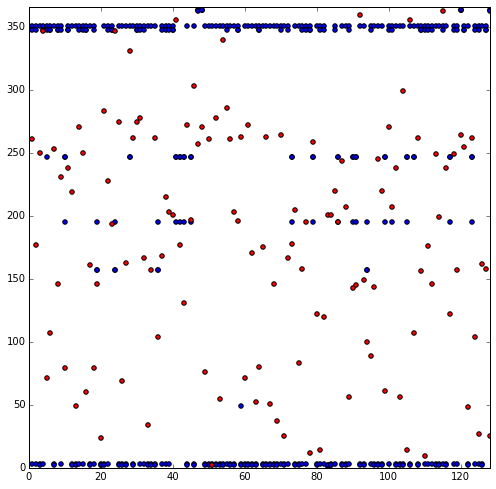

In [15]:
get_ipython().magic('matplotlib inline')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import random
get_ipython().magic('matplotlib inline')

def formatDataForYearPlot(hashFormatted, topK=3):
    x = []
    y = []
    xActuals = []
    yActuals = []
    for key in hashFormatted.keys():
        for k in range(topK):
            x.append(key)
#             print(hashFormatted[key][2][k][1][0])
            y.append(hashFormatted[key][2][k][1][0])
    for key in hashFormatted.keys():
        xActuals.append(key)
        yActuals.append(hashFormatted[key][0][0])
    return x, y, xActuals, yActuals
    



def plotYear(hashFormatted=hashFormatted, topK=3):

    x, y, xActuals, yActuals = formatDataForYearPlot(hashFormatted, topK)

    # the random data
#     x = [random.randint(1, 365) for x in range(1000)]
#     y = np.random.randn(1000)

    nullfmt   = NullFormatter()         # no labels

    # definitions for the axes
    left, width = 0.1, 0.8
    bottom, height = 0.1, 0.8
    bottom_h = left_h = left+width+0.02

    rect_scatter = [left, bottom, width, height]
    # rect_histx = [left, bottom_h, width, 0.2]
    # rect_histy = [left_h, bottom, 0.2, height]

    # start with a rectangular Figure
    plt.figure(1, figsize=(8,8))

    axScatter = plt.axes(rect_scatter)
    # axHistx = plt.axes(rect_histx)
    # axHisty = plt.axes(rect_histy)

    # no labels
#     axHistx.xaxis.set_major_formatter(nullfmt)
    # axHisty.yaxis.set_major_formatter(nullfmt)

    # the scatter plot:
    axScatter.scatter(x, y)
    axScatter.scatter(xActuals, yActuals, c='r')

    # now determine nice limits by hand:
    binwidth = 0.25
    # xymax = np.max( [np.max(np.fabs(x)), np.max(np.fabs(y))] )
    # lim = ( int(xymax/binwidth) + 1) * binwidth

    axScatter.set_xlim( (0, 128) )
    axScatter.set_ylim( (0, 366) )

    # bins = np.arange(-lim, lim + binwidth, binwidth)
    # axHistx.hist(x, bins=bins)
    # axHisty.hist(y, bins=bins, orientation='horizontal')

    # axHistx.set_xlim( axScatter.get_xlim() )
    # axHisty.set_ylim( axScatter.get_ylim() )

    plt.show()
    
plotYear()

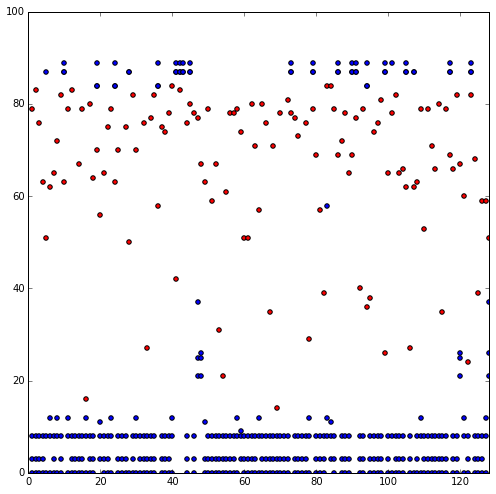

In [16]:
def formatDataForTempPlot(hashFormatted, topK=3):
    x = []
    y = []
    xActuals = []
    yActuals = []
    for key in hashFormatted.keys():
        for k in range(topK):
            x.append(key)
#             print(hashFormatted[key][2][k][1][2])
            if hashFormatted[key][2][k][1][2] == 'N/A':
                y.append(-10)
            else:
                y.append(hashFormatted[key][2][k][1][2])
    for key in hashFormatted.keys():
        xActuals.append(key)
        if hashFormatted[key][0][2] == 'N/A':
            yActuals.append(-10)
        else:
            yActuals.append(hashFormatted[key][0][2])
    return x, y, xActuals, yActuals
    



def plotTemp(hashFormatted=hashFormatted, topK=3):

    x, y, xActuals, yActuals = formatDataForTempPlot(hashFormatted, topK)

    # the random data
#     x = [random.randint(1, 365) for x in range(1000)]
#     y = np.random.randn(1000)

    nullfmt   = NullFormatter()         # no labels

    # definitions for the axes
    left, width = 0.1, 0.8
    bottom, height = 0.1, 0.8
    bottom_h = left_h = left+width+0.02

    rect_scatter = [left, bottom, width, height]
    # rect_histx = [left, bottom_h, width, 0.2]
    # rect_histy = [left_h, bottom, 0.2, height]

    # start with a rectangular Figure
    plt.figure(1, figsize=(8,8))

    axScatter = plt.axes(rect_scatter)
    # axHistx = plt.axes(rect_histx)
    # axHisty = plt.axes(rect_histy)

    # no labels
#     axHistx.xaxis.set_major_formatter(nullfmt)
    # axHisty.yaxis.set_major_formatter(nullfmt)

    # the scatter plot:
    axScatter.scatter(x, y)
    axScatter.scatter(xActuals, yActuals, c='r')

    # now determine nice limits by hand:
    binwidth = 0.25
    # xymax = np.max( [np.max(np.fabs(x)), np.max(np.fabs(y))] )
    # lim = ( int(xymax/binwidth) + 1) * binwidth

    axScatter.set_xlim( (0, 128) )
    axScatter.set_ylim( (0, 100) )

    # bins = np.arange(-lim, lim + binwidth, binwidth)
    # axHistx.hist(x, bins=bins)
    # axHisty.hist(y, bins=bins, orientation='horizontal')

    # axHistx.set_xlim( axScatter.get_xlim() )
    # axHisty.set_ylim( axScatter.get_ylim() )

    plt.show()
    
plotTemp()

# Define all the functions 

In [8]:
def runNumRSMLEAcross(predictedDict, compareTotalArr):
    numberOfPredictors = 4
    global RSMLEList
    RSMLEList = []
    for key,val in predictedDict.items():
        RSMLEList.append(EvaluationNumRSMLE(val, compareTotalArr[key][numberOfPredictors:]))
    print(RSMLEList)
    print(statistics.mean(RSMLEList))

def EvaluationNumRSMLE(predictedArr, compareSingleArr):
    tempLog = 0
    for x in range(111):
        tempLog = tempLog + (math.log(predictedArr[x] + 1) - math.log(compareSingleArr[x] + 1))**2
    toRoot = (1/111)*tempLog
    RSMLE = math.sqrt(toRoot)
    return RSMLE

def runCalcAcross(k, simDict):
    predictedDict = {}
    for key,val in simDict.items():
        tempPredArr = calcUnits(k, val)
        predictedDict[key] = tempPredArr
    print("Done")
    return predictedDict

def calcUnits(k, simArr):
    workDict = simArr[:k]
    kmax = max(workDict)[0]
    weightTot = 0
    predictedArr = [0]*111
    wieghtSumArr = [0]*111
    for x in workDict:
        itemsArr = x[1] 
        weight = (x[0]/kmax)
        weightTot += weight
        for i in range(111):
            wieghtSumArr[i] = wieghtSumArr[i] + (itemsArr[i]*weight)
    for i in range(111):
            predictedArr[i] = (wieghtSumArr[i]/weightTot)
    return predictedArr

def sim(trainingData, testData, tempStdev):
    simDictFORPLOT = {}
    numberOfPredictors = 4
    tempIndexTest = 0 
    testKScoredArr = {}
    for compare in testData:
        simArr = []
        simArrFORPLOT= []
        for x in trainingData:
            tempScore = 0
            dateDist = abs(compare[0] - x[0])
            tempScore += 10 - (dateDist/365)*10
            if x[2] != 'N/A' and compare[2] != 'N/A':
                tempuratureDist = abs(compare[2] - x[2])
                tempScore += 10 - (tempuratureDist/tempStdev)*10
            if x[1] == compare[1]:
                tempScore += 3
            if x[3] == compare[3]:
                tempScore += 1
            simArr.append((float(tempScore), x[numberOfPredictors:]))
            simArrFORPLOT.append((float(tempScore), x))
        simArr.sort()
        simArrFORPLOT.sort()
        simArr.reverse()
        simArrFORPLOT.sort()
        testKScoredArr[tempIndexTest] = simArr
        simDictFORPLOT[tempIndexTest] = simArrFORPLOT
        tempIndexTest+=1
    print("Done")
    return testKScoredArr, simDictFORPLOT

def calculateSTDEV(trainingData):
    tempCalc = []
    for x in trainingData:
        if x[2] != 'N/A':
            tempCalc.append(x[2])
    stDev= statistics.stdev(tempCalc)
    print(stDev)
    return stDev

def createTestAndTrain(data):
    trainingData = copy.deepcopy(data)
    testData = []
    for i in range(len(trainingData)//10):
        testData.append(trainingData.pop(random.randint(0, len(trainingData)-1)))
    print("Done")
    return trainingData, testData

def changeDateCreateKNNList(trainedPreStoreDict):
    dataList = []
    for key,value in trainedPreStoreDict.items():
        for x in range(len(value)):
            try:
                tempDate = trainedPreStoreDict[key][x][0]
                struct_time = time.strptime(tempDate, "%Y-%m-%d")
                trainedPreStoreDict[key][x][0] = struct_time.tm_yday
                dataList.append(trainedPreStoreDict[key][x])
            except TypeError:
                print("AlreadyFormatted")
                break
    print("Done")
    return dataList

def buildPredictorTargetArr(keyDict, trainDict, notedDays, weatherDict):
    indexJump = 3
    arrSize = 115
    toreturn = {}
    for storeKey in range(1,46):
        dayArr = notedDays[storeKey]
        for x in dayArr:
                if x != 0:
                    if toreturn.get(storeKey) is None:
                        tempArr = [0]*arrSize
                        tempdate = x[0]
                        tempArr[0] = tempdate
                        tempArr[1] = int(keyDict[str(storeKey)][0][0])
                        tempArr[3] = storeKey
                        try:
                            tempArr[2] = int(x[3])
                        except ValueError:
                            tempArr[2] = 'N/A'
                        try:
                            tempIter = trainDict[tempdate]
                        except KeyError:
                            print(str(x) + " Failed")
                        for i in tempIter:
                            if int(i[0]) == storeKey:
                                tempIndex = int(i[1]) + indexJump
                                tempArr[tempIndex] = int(i[2])
                        toreturn[storeKey] = []
                        toreturn[storeKey].append(tempArr)
                    else:
                        tempdate = x[0]
                        try:
                            tempIter = trainDict[tempdate]
                        except KeyError:
                            print(str(x[0]) + " Failed")
                        tempArr = [0]*arrSize
                        tempArr[0] = tempdate
                        tempArr[1] = int(keyDict[str(storeKey)][0][0])
                        tempArr[3] = storeKey
                        try:
                            tempArr[2] = int(x[3])
                        except ValueError:
                            tempArr[2] = 'N/A'
                        for i in tempIter:
                            if int(i[0]) == storeKey:
                                tempIndex = int(i[1]) + indexJump
                                tempArr[tempIndex] = int(i[2])
                        toreturn[storeKey].append(tempArr)
    print("Done")
    return toreturn

def buildNotedDaysHash(keyDict, weatherDict):
    toreturn = {}
    for storeKey in range(1,46):
        stationKey = keyDict[str(storeKey)][0][0]
        weatherData = weatherDict[str(stationKey)]
        first = True
        for dayData in weatherData:
            isNoted = 0
            try:
                if float(dayData[12]) > 2:
                    isNoted = dayData
            except ValueError:
                pass
            try:
                if float(dayData[13]) > 1:
                    isNoted = dayData
            except ValueError:
                pass
            if first:
                toreturn[storeKey] = []
                toreturn[storeKey].append(isNoted)
                first = False
            else:
                toreturn[storeKey].append(isNoted)
    print("Done")
    return toreturn

def loadData(fname, dataStructure):
    count = 0
    with open(fname) as f:
        content = f.readlines()
    for line in content:
        if count is not 0:
            line = line.strip()
            line = line.split(',')
            if dataStructure.get(line[0]) is None:
                dataStructure[line[0]] = []
                dataStructure[line[0]].append(line[1:])
            else:
                dataStructure[line[0]].append(line[1:])
        count+=1
    print("Done " + fname)
        
def loadFiles():
    global keyDict, trainDict, weatherDict
    keyDict = {}
    weatherDict = {}
    trainDict = {}
    dataStruct = [keyDict, trainDict, weatherDict]
    count=0
    for x in ['key.csv', 'train.csv', 'weather.csv']:
        loadData(x, dataStruct[count])
        count+=1

# BELOW THIS IS WORK DONE BUT NEVER USED

In [17]:
def keyDictForKNN(keyDict):
    modKeyDict = {}
    dictList = []
    for key,values in keyDict.items():
        tempVal = int(values[0][0])
        tempKey = int(key)
        if tempKey not in dictList:
            dictList.append(tempKey)
            modKeyDict[tempKey] = tempVal
    print("Done")
    return modKeyDict


global modKeyDict        
modKeyDict = keyDictForKNN(keyDict)

Done


In [18]:
def KNNCatagoryHashGen(dataList, modKeyDict):
    wTowerCatagoryHash = {}
    dayCatagoryHash = {}
    for x in dataList:
        stationKey = modKeyDict[x[1]]
        dayNum = x[0]
        dayCatagoryHash = insertdayCatagoryHash(dayCatagoryHash, dayNum, x)
        wTowerCatagoryHash = insertwTowerCatagoryHash(wTowerCatagoryHash, stationKey, x)
    print("Done")
    return dayCatagoryHash, wTowerCatagoryHash
        
def insertdayCatagoryHash(dayCatagoryHash, dayNum ,x):
    if dayCatagoryHash.get(dayNum) is None:
        dayCatagoryHash[dayNum] = []
        dayCatagoryHash[dayNum].append(x)
    else:
        dayCatagoryHash[dayNum].append(x)
    return dayCatagoryHash
    
def insertwTowerCatagoryHash(wTowerCatagoryHash, stationKey, x):
    if wTowerCatagoryHash.get(stationKey) is None:
        wTowerCatagoryHash[stationKey] = []
        wTowerCatagoryHash[stationKey].append(x)
    else:
        wTowerCatagoryHash[stationKey].append(x)
    return wTowerCatagoryHash
        
        
global dayCatagoryHash, wTowerCatagoryHash
[dayCatagoryHash, wTowerCatagoryHash] = KNNCatagoryHashGen(dataList, modKeyDict)
global featureSet
featureSet = [dayCatagoryHash, wTowerCatagoryHash]

Done


In [11]:
%matplotlib inline

import matplotlib

import numpy as np

import matplotlib.pyplot as plt

print("Done")

Done


In [ ]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt


dayArr = [0]*364
towArr = [0]*20

for key,val in dayCatagoryHash.items():
    dayArr[key-1] = len(val)
    
for key,val in wTowerCatagoryHash.items():
    towArr[key-1] = len(val)

# # example data
mu = 100 # mean of distribution
sigma = 15 # standard deviation of distribution
# x = mu + sigma * np.random.randn(10000)

num_bins = 365
# the histogram of the data
n, bins, patches = plt.hist(dayArr, num_bins, normed=1, facecolor='green', alpha=0.5)
# add a 'best fit' line
y = num_bins
plt.plot(bins, n, 'r--')

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

In [ ]:

N = 50
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
area = np.pi * (15 * np.random.rand(N))**2 # 0 to 15 point radiuses

# print(x)
# print(y)
# print(colors)
# print(area)

dayArr = [0]*364
towArr = [0]*20

for key,val in dayCatagoryHash.items():
    dayArr[key-1] = len(val)
    
count=0
countI=0
dayArrAdjust=[0]*20
for x in dayArr:
    dayArrAdjust[countI] = dayArrAdjust[countI] + x
    if count%19 == 18:
        countI+=1
    count+=1
    
    
print(dayArrAdjust)

for key,val in wTowerCatagoryHash.items():
    towArr[key-1] = len(val)
    
print(towArr)
print(colors[:20])

Darea = [0]*20
Tarea = [0]*20
Farea = [0]*20
for x in range(towArr):
    Tarea[x]=towArr[x]/max(towArr)
    
for x in range(dayArrAdjust):
    Darea[x]=dayArrAdjust[x]/max(dayArrAdjust)
    
for x in range(Tarea):
    Farea[x] = (Tarea[x]+Darea[x])/2
print(Farea)

plt.scatter(dayArrAdjust, towArr, s=area, c=colors, alpha=0.5)
plt.show()

In [ ]:
def sim(featureSet, comp, temp):
    ksd = simDay( featureSet[0], comp[0], temp[0] ) 
    kwt = simWTower( featureSet[1], comp[1], temp[1] ) 
    
    
def simDay( dayCatagoryHash, compDay, tempDay):
    for key,val in dayCatagoryHash.items():
        sVal = key - 
        